# Pipeline for the anomaly detection on the SkAB using FF Autoencoder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from evaluating import evaluating_change_point

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# data loading
list_of_df = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file in all_files]

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(all_files)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 35

Shape of the random dataset: (1155, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 12938

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027533,0.040251,1.225920,0.054711,70.6086,25.0660,230.831,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027638,0.040555,1.212700,0.054711,70.6873,25.0797,232.721,32.0109,0.0,0.0
2020-03-09 12:14:38,0.027355,0.039930,1.353730,0.710565,70.7463,25.0850,251.194,32.9894,0.0,0.0
2020-03-09 12:14:39,0.028318,0.042112,0.813039,-0.273216,70.5657,25.0730,235.222,32.0000,0.0,0.0
2020-03-09 12:14:40,0.027336,0.040441,1.237940,0.054711,70.5550,25.0799,228.685,32.0109,0.0,0.0


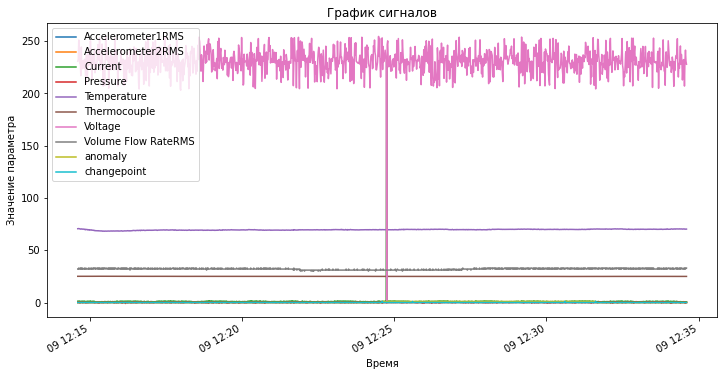

In [20]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Время')
plt.ylabel('Значение параметра')
plt.title(f'График сигналов')
plt.show()

## Labels

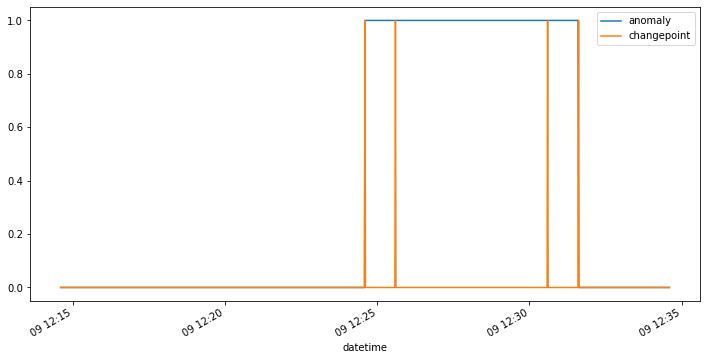

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,6))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [29]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

In [25]:
# Function for repeatability
def Random(seed_value):
    # Seed value
    # Apparently you may use different seed values at each stage
    seed_value= seed_value

    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [21]:
# train set selection
X_train = list_of_df[0][:'2020-03-09 12:21'].drop(['anomaly','changepoint'], axis=1)

X_val = list_of_df[1][:'2020-03-09 12:41'].drop(['anomaly','changepoint'], axis=1)
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO

In [15]:
StSc = StandardScaler()

# scaler fitting
StSc.fit(X_train)

StandardScaler()

In [38]:
def arch(param, data):
    Random(0)
    input_dots = Input((8,))

    x = Dense(param[0])(input_dots)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Dense(param[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    bottleneck = Dense(param[2], activation='linear')(x)

    x = Dense(param[1])(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[0])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(8, activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(param[3]), loss='mae', metrics=["mse"])
    
    early_stopping = EarlyStopping(patience=3, verbose=1)
    model.fit(data, data,
                validation_split=0.2,
                epochs=40,
                batch_size=param[4],
                verbose=0,
                shuffle=True,
                callbacks=[early_stopping]
               )
    return model

In [70]:
n1=[6, 5]
n2=[4, 3]
n3=[2, 1]
lr=[0.01, 0.005, 0.001]
batch_size=[32, 64, 128]

parameters = product(n1, n2, n3, lr, batch_size)
parameters_list = list(parameters)
print(f'Total number of parameter combinations: {len(parameters_list)}')

Total number of parameter combinations: 72


In [71]:
pd.DataFrame(parameters_list, columns=['neurons 1st layer',
                                      'neurons 2nd layer',
                                      'neurons 3rd layer',
                                      'learning rate',
                                      'batch size'])

,neurons 1st layer,neurons 2nd layer,neurons 3rd layer,learning rate,batch size
0,6,4,2,0.010,32
1,6,4,2,0.010,64
2,6,4,2,0.010,128
3,6,4,2,0.005,32
4,6,4,2,0.005,64
...,...,...,...,...,...
67,5,3,1,0.005,64
68,5,3,1,0.005,128
69,5,3,1,0.001,32
70,5,3,1,0.001,64


### Hyperparameters selection

In [72]:
errors = []
for params in parameters_list:
    
    model = arch(params, StSc.transform(X_train))
    train_pred = model.predict(StSc.transform(X_train), batch_size=params[4])
    val_pred = model.predict(StSc.transform(X_val), batch_size=params[4])
    
    train_error = mean_absolute_error(StSc.transform(X_train), train_pred)
    val_error = mean_absolute_error(StSc.transform(X_val), val_pred)
    
    errors.append(list(params)+[train_error, val_error])
    
df_errors = pd.DataFrame(errors,
                         columns=['neurons 1st layer', 
                                  'neurons 2nd layer', 
                                  'neurons 3rd layer', 
                                  'learning rate', 
                                  'batch size', 
                                  'mae train', 
                                  'mae val'])
df_errors.sort_values('mae val').head()

Epoch 00010: early stopping
Epoch 00024: early stopping
Epoch 00025: early stopping
Epoch 00016: early stopping
Epoch 00030: early stopping
Epoch 00029: early stopping
Epoch 00022: early stopping
Epoch 00022: early stopping
Epoch 00012: early stopping
Epoch 00032: early stopping
Epoch 00030: early stopping
Epoch 00020: early stopping
Epoch 00010: early stopping
Epoch 00015: early stopping
Epoch 00024: early stopping
Epoch 00014: early stopping
Epoch 00021: early stopping
Epoch 00035: early stopping
Epoch 00031: early stopping
Epoch 00019: early stopping
Epoch 00026: early stopping
Epoch 00021: early stopping
Epoch 00039: early stopping
Epoch 00040: early stopping
Epoch 00026: early stopping
Epoch 00018: early stopping
Epoch 00005: early stopping
Epoch 00040: early stopping
Epoch 00022: early stopping
Epoch 00018: early stopping
Epoch 00006: early stopping
Epoch 00019: early stopping
Epoch 00004: early stopping
Epoch 00021: early stopping
Epoch 00031: early stopping
Epoch 00007: early s

,neurons 1st layer,neurons 2nd layer,neurons 3rd layer,learning rate,batch size,mae train,mae val
1,6,4,2,0.010,64,0.657569,1.152854
19,6,3,2,0.010,64,0.674359,1.153123
39,5,4,2,0.005,32,0.564909,1.181283
28,6,3,1,0.010,64,0.662206,1.183940
4,6,4,2,0.005,64,0.655558,1.185610


### Best model fitting

In [73]:
best_params = parameters_list[df_errors.sort_values('mae val').index[0]]

model = arch(best_params, StSc.transform(X_train))
model.summary()

Epoch 00024: early stopping
Model: "functional_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_588 (Dense)            (None, 6)                 54        
_________________________________________________________________
batch_normalization_392 (Bat (None, 6)                 24        
_________________________________________________________________
activation_392 (Activation)  (None, 6)                 0         
_________________________________________________________________
dense_589 (Dense)            (None, 4)                 28        
_________________________________________________________________
batch_normalization_393 (Bat (None, 4)                 16        
_________________________________________________________________
activation_393 (Activati

In [135]:
val_residuals = StSc.transform(X_val) - model.predict(StSc.transform(X_val))
train_residuals = StSc.transform(X_train) - model.predict(StSc.transform(X_train))

UCL = abs(pd.DataFrame(val_residuals)).sum(axis=1).quantile(0.90)

In [141]:
# inference
prediction = []
for df in list_of_df:
    df_sc = StSc.transform(df.drop(['anomaly','changepoint'], axis=1))
    ae_residuals = df_sc - model.predict(df_sc)
    ae = abs(pd.DataFrame(ae_residuals)).sum(axis=1)
    prediction.append(pd.Series((ae>UCL).astype(int).values, 
                                index=df.index).fillna(0))

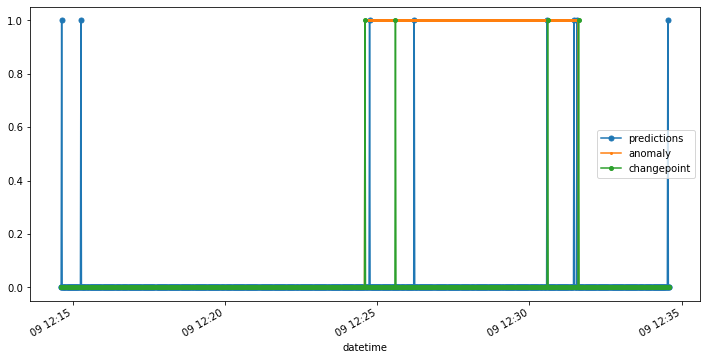

In [142]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

prediction[0].plot(figsize=(12,6), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
true_cp[0].plot(marker='o', markersize=4)
plt.legend();

In [143]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, prediction, metric='binary', numenta_time='30 sec')

False Alarm Rate 90.82 %
Missing Alarm Rate 7.64 %


/Users/iurii.katser/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [144]:
# average detection delay metric calculation
# Missing values means a number of not detected changepoints
add = evaluating_change_point(true_cp, prediction, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:00.196850
Missing values: 3


In [145]:
# nab metric calculation
nab = evaluating_change_point(true_cp, prediction, metric='nab', numenta_time='30 sec')

большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
Standart  -  -810.81
LowFP  -  -1719.71
LowFN  -  -507.72
